**Content based book recommendation system**, which will determine which books are close to each other based on how similar the discussed topics are. The dataset consists of books written by Darwin.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob
import re, os
import pickle
from nltk.stem import PorterStemmer
from gensim.models import TfidfModel
from gensim import similarities
from gensim import corpora
from scipy.cluster import hierarchy

%matplotlib inline

In [2]:
folder = "datasets_books/"
files = glob.glob(folder + '*.txt')
files.sort()

files

['datasets_books\\Autobiography.txt',
 'datasets_books\\CoralReefs.txt',
 'datasets_books\\DescentofMan.txt',
 'datasets_books\\DifferentFormsofFlowers.txt',
 'datasets_books\\EffectsCrossSelfFertilization.txt',
 'datasets_books\\ExpressionofEmotionManAnimals.txt',
 'datasets_books\\FormationVegetableMould.txt',
 'datasets_books\\FoundationsOriginofSpecies.txt',
 'datasets_books\\GeologicalObservationsSouthAmerica.txt',
 'datasets_books\\InsectivorousPlants.txt',
 'datasets_books\\LifeandLettersVol1.txt',
 'datasets_books\\LifeandLettersVol2.txt',
 'datasets_books\\MonographCirripedia.txt',
 'datasets_books\\MonographCirripediaVol2.txt',
 'datasets_books\\MovementClimbingPlants.txt',
 'datasets_books\\OriginofSpecies.txt',
 'datasets_books\\PowerMovementPlants.txt',
 'datasets_books\\VariationPlantsAnimalsDomestication.txt',
 'datasets_books\\VolcanicIslands.txt',
 'datasets_books\\VoyageBeagle.txt']

Basic pre-processing 

In [3]:
txts = []
titles = []

for n in files:
    f = open(n, encoding='utf-8-sig')
    # Remove non-alpha-numeric characters
    data = re.sub('[\W_]+', ' ', f.read())
    # Store the texts and titles of the books
    titles.append(os.path.basename(n).replace('.txt', ''))
    txts.append(data)

[len(t) for t in txts]

[123231,
 496068,
 1776539,
 617088,
 913713,
 624232,
 335920,
 523021,
 797401,
 901406,
 1047518,
 1010643,
 767492,
 1660866,
 298319,
 916267,
 1093567,
 1043499,
 341447,
 1149574]

In [4]:
# Finding Darwin's most famous book: "On the Origin of Species" for analysis
for i in range(len(titles)):
    if(titles[i]=="OriginofSpecies"):
        ori = i
print(ori)

15


Tokenizing the corpus. <br/>
Transforming each text into a list of the individual words.

In [5]:
# Defining a list of stop words
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())

txts_lower_case = [txt.lower() for txt in txts]
txts_split = [txt.split() for txt in txts_lower_case]
# Removing tokens which are part of the list of stop words
texts = [[word for word in txt if word not in stoplist] for txt in txts_split]

texts[ori][:10]

['on',
 'origin',
 'species',
 'but',
 'with',
 'regard',
 'material',
 'world',
 'can',
 'least']

Stemming

In [6]:
# Porter stemming from the nltk package
porter = PorterStemmer()

texts_stem = [[porter.stem(token) for token in text] for text in texts]

pickle.dump( texts_stem, open( "datasets_books/texts_stem.p", "wb" ) )

In [7]:
texts_stem = pickle.load(open("datasets_books/texts_stem.p", "rb"))

texts_stem[ori][:10]

['on',
 'origin',
 'speci',
 'but',
 'with',
 'regard',
 'materi',
 'world',
 'can',
 'least']

Building a bag-of-words model

In [8]:
dictionary = corpora.Dictionary(texts_stem)
bows = [dictionary.doc2bow(txt) for txt in texts_stem]

bows[ori][:5]

[(0, 11), (5, 51), (6, 1), (8, 2), (21, 1)]

most common words of a given book

In [9]:
df_bow_origin = pd.DataFrame(bows[ori])

df_bow_origin.columns = ['index', 'occurrences']
df_bow_origin['token'] = df_bow_origin['index'].apply(lambda x: dictionary[x])

df_bow_origin = df_bow_origin.sort_values('occurrences', ascending=False)
df_bow_origin.head(10)

,index,occurrences,token
748,1168,2023,have
1119,1736,1558,on
1489,2288,1543,speci
892,1366,1480,it
239,393,1362,by
1128,1747,1201,or
125,218,1140,are
665,1043,1137,from
1774,2703,1000,with
1609,2452,962,thi


Build a tf-idf model

In [12]:
model = TfidfModel(bows)

model[bows[ori]][:10]

[(8, 0.00020408683039616044),
 (21, 0.0005723177174474165),
 (23, 0.001714008058633542),
 (27, 0.0006466337090765656),
 (28, 0.0025710120879503125),
 (31, 0.000857004029316771),
 (35, 0.001016241827361025),
 (36, 0.001016241827361025),
 (51, 0.0008878482198272165),
 (54, 0.00203248365472205)]

In [13]:
df_tfidf = pd.DataFrame(model[bows[ori]])

df_tfidf.columns = ['id', 'score']
df_tfidf['token'] = df_tfidf['id'].apply(lambda x: dictionary[x])

df_tfidf = df_tfidf.sort_values('score', ascending=False)
df_tfidf.head(10)

,id,score,token
880,2164,0.327823,select
3103,10108,0.204162,pigeon
128,369,0.197968,breed
2985,9395,0.167705,migrat
947,2325,0.148371,steril
285,752,0.146172,domest
504,1255,0.128433,hybrid
371,966,0.127694,fertil
3840,16046,0.124547,gärtner
3536,12729,0.121348,naturalis


Compute distance between texts

In [14]:
sims = similarities.MatrixSimilarity(model[bows])

sim_df = pd.DataFrame(list(sims))
sim_df.columns = titles
sim_df.index = titles

sim_df

,Autobiography,CoralReefs,DescentofMan,DifferentFormsofFlowers,EffectsCrossSelfFertilization,ExpressionofEmotionManAnimals,FormationVegetableMould,FoundationsOriginofSpecies,GeologicalObservationsSouthAmerica,InsectivorousPlants,LifeandLettersVol1,LifeandLettersVol2,MonographCirripedia,MonographCirripediaVol2,MovementClimbingPlants,OriginofSpecies,PowerMovementPlants,VariationPlantsAnimalsDomestication,VolcanicIslands,VoyageBeagle
Autobiography,1.000000,0.049722,0.080789,0.066615,0.077006,0.089345,0.041182,0.058990,0.030679,0.014945,0.399534,0.220023,0.005854,0.008456,0.022999,0.101199,0.016059,0.048989,0.038630,0.184288
CoralReefs,0.049722,1.000000,0.009516,0.001980,0.001936,0.005062,0.029445,0.022066,0.060744,0.002284,0.031211,0.017772,0.006321,0.010497,0.001534,0.039200,0.002686,0.011383,0.057402,0.267414
DescentofMan,0.080789,0.009516,1.000000,0.072792,0.029997,0.148642,0.027106,0.135001,0.009628,0.009468,0.060040,0.080569,0.053426,0.042937,0.005157,0.267734,0.011267,0.228437,0.007885,0.123902
DifferentFormsofFlowers,0.066615,0.001980,0.072792,1.000000,0.391788,0.006545,0.010621,0.039993,0.002855,0.007487,0.016188,0.046692,0.009403,0.005451,0.008165,0.129152,0.018831,0.049405,0.002624,0.013213
EffectsCrossSelfFertilization,0.077006,0.001936,0.029997,0.391788,1.000000,0.006871,0.032270,0.040248,0.002247,0.006763,0.019609,0.046567,0.003218,0.002957,0.014939,0.146700,0.039520,0.054458,0.002183,0.017183
ExpressionofEmotionManAnimals,0.089345,0.005062,0.148642,0.006545,0.006871,1.000000,0.021066,0.047103,0.005246,0.011461,0.065391,0.049333,0.016802,0.029644,0.005942,0.063242,0.011234,0.082567,0.005595,0.099124
FormationVegetableMould,0.041182,0.029445,0.027106,0.010621,0.032270,0.021066,1.000000,0.021468,0.067712,0.035498,0.028357,0.023943,0.019864,0.023915,0.038823,0.049519,0.039911,0.032647,0.059299,0.098331
FoundationsOriginofSpecies,0.058990,0.022066,0.135001,0.039993,0.040248,0.047103,0.021468,1.000000,0.027300,0.005995,0.057749,0.054703,0.007650,0.010762,0.003971,0.322736,0.008712,0.196578,0.017528,0.089075
GeologicalObservationsSouthAmerica,0.030679,0.060744,0.009628,0.002855,0.002247,0.005246,0.067712,0.027300,1.000000,0.006844,0.028691,0.012241,0.009260,0.023486,0.002046,0.052878,0.003450,0.013737,0.372272,0.259514
InsectivorousPlants,0.014945,0.002284,0.009468,0.007487,0.006763,0.011461,0.035498,0.005995,0.006844,1.000000,0.006062,0.016549,0.019091,0.019657,0.249011,0.014982,0.022841,0.010321,0.008526,0.014758


The book most similar to "On the Origin of Species"

Text(0.5, 1.0, 'Similarity')

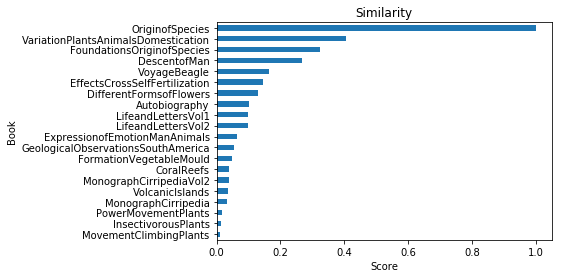

In [15]:
v = sim_df['OriginofSpecies']

v_sorted = v.sort_values()
v_sorted.plot.barh(x='lab', y='val', rot=0).plot()

plt.xlabel("Score")
plt.ylabel("Book")
plt.title("Similarity")

Which books have similar content?

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [75.0, 75.0, 85.0, 85.0],
  [95.0, 95.0, 105.0, 105.0],
  [115.0, 115.0, 125.0, 125.0],
  [100.0, 100.0, 120.0, 120.0],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [160.0, 160.0, 182.5, 182.5],
  [140.0, 140.0, 171.25, 171.25],
  [110.0, 110.0, 155.625, 155.625],
  [80.0, 80.0, 132.8125, 132.8125],
  [43.75, 43.75, 106.40625, 106.40625],
  [12.5, 12.5, 75.078125, 75.078125]],
 'dcoord': [[0.0, 0.2612530188646834, 0.2612530188646834, 0.0],
  [0.0, 1.3180936526186984, 1.3180936526186984, 0.2612530188646834],
  [0.0, 0.8694240710392087, 0.8694240710392087, 0.0],
  [0.0, 1.1384443326242986, 1.1384443326242986, 0.8694240710392087],
  [0.0, 1.201073455716524, 1.201073455716524, 1.1384443326242986],
  [0.0, 0.6850870074973991, 0.6850870074973991, 0.0],
  [0.0, 

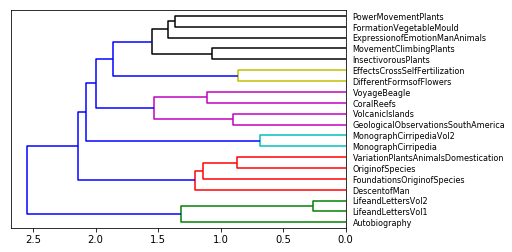

In [16]:
# Computing the clusters from the similarity matrix,
# using the Ward variance minimization algorithm
Z = hierarchy.linkage(sims, 'ward')

hierarchy.dendrogram(Z, leaf_font_size=8, labels=sim_df.index, orientation='left')